📦 Building dataset...


100%|██████████| 101/101 [00:08<00:00, 12.41it/s]


✅ Total usable samples: 101
BasicUNet features: (32, 32, 64, 128, 256, 32).
🚀 Training...
[Epoch 1] Loss: 40.5893
[Epoch 2] Loss: 36.2061
[Epoch 3] Loss: 34.5705
[Epoch 4] Loss: 33.5534
[Epoch 5] Loss: 32.7446
[Epoch 6] Loss: 32.0520
[Epoch 7] Loss: 31.4546
[Epoch 8] Loss: 30.9523
[Epoch 9] Loss: 30.5228
[Epoch 10] Loss: 30.1507
✅ Model saved
🧪 Evaluating...
🧠 Lesions predicted in test set: 0 / 21

📊 Test Set Detection-Level Metrics:
✅ Accuracy:  0.7143
✅ Precision: 0.0000
✅ Recall:    0.0000
✅ F1 Score:  0.0000


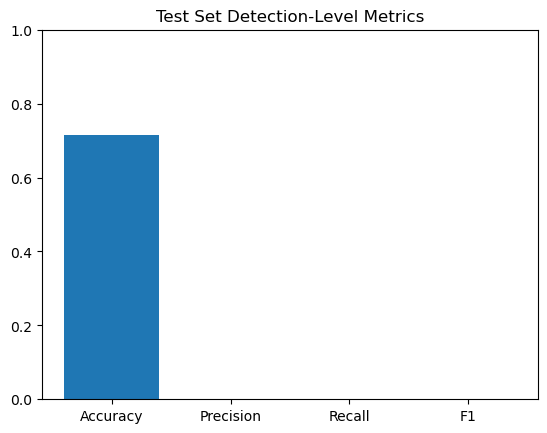

In [29]:
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from monai.networks.nets import BasicUNet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised
)

# ==== SETUP ====
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== PATHS ====
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# ==== LOAD METADATA ====
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

# ==== UTILS ====
def load_dicom_volume(proxid, series_description="ADC"):
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    for root, _, _ in os.walk(patient_dir):
        if series_description.lower() in root.lower():
            dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
            if dicoms:
                reader = sitk.ImageSeriesReader()
                reader.SetFileNames(dicoms)
                return reader.Execute()
    raise FileNotFoundError(f"{proxid}: ADC not found.")

def load_ktrans(proxid):
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    if os.path.exists(path):
        return sitk.ReadImage(path)
    raise FileNotFoundError(f"{proxid}: Ktrans missing.")

def parse_ijk(ijk_str):
    try:
        parts = ijk_str.strip().replace(",", " ").split()
        return tuple(map(int, parts))
    except:
        return None

def generate_label_mask(image, ijk_list):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try:
            label[int(k), int(j), int(i)] = 1
        except:
            continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

# ==== BUILD DATASET ====
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print("📦 Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid)
        ktrans = load_ktrans(proxid)
        ktrans = sitk.Resample(ktrans, adc)

        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]

        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        adc_path = f"images/{proxid}_adc.nii.gz"
        ktrans_path = f"images/{proxid}_ktrans.nii.gz"
        mask_path = f"labels/{proxid}_label.nii.gz"

        sitk.WriteImage(adc, adc_path)
        sitk.WriteImage(ktrans, ktrans_path)
        sitk.WriteImage(mask, mask_path)

        data.append({"image": [adc_path, ktrans_path], "label": mask_path})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f"❌ {proxid}: {e}")

print(f"✅ Total usable samples: {len(data)}")

# ==== BALANCE POSITIVE/NEGATIVE FOR TRAINING ONLY ====
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]

seed(42)
no_lesion_sampled = sample(no_lesion, len(has_lesion))

balanced_train_data = has_lesion + no_lesion_sampled
balanced_train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)

# Stratified split for TEST SET only
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Final train split uses only balanced subset (no further split needed)
train_data = balanced_train_data
train_labels = balanced_train_labels

# ==== TRANSFORMS ====
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    RandGaussianNoised(keys="image", prob=0.2),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

# ==== LOADERS ====
train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)


# ==== MODEL ====
model = BasicUNet(spatial_dims=3, in_channels=2, out_channels=2).to(device)
loss_fn = DiceFocalLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ==== TRAIN ====
print("🚀 Training...")
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "prostate_seg_model.pth")
print("✅ Model saved")

# ==== EVALUATE ====
print("🧪 Evaluating...")
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()

        y_true.append(int(np.any(true_mask)))
        y_pred.append(int(np.any(pred_mask)))

# ==== METRICS ====
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

nonzero_preds = sum(np.any(p) for p in y_pred)
print(f"🧠 Lesions predicted in test set: {nonzero_preds} / {len(test_data)}")

print("\n📊 Test Set Detection-Level Metrics:")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# ==== PLOT ====
plt.bar(["Accuracy", "Precision", "Recall", "F1"], [acc, prec, rec, f1])
plt.ylim(0, 1)
plt.title("Test Set Detection-Level Metrics")
plt.show()


📦 Building dataset...


100%|██████████| 101/101 [01:02<00:00,  1.62it/s]


✅ Total usable samples: 101
BasicUNet features: (32, 32, 64, 128, 256, 32).
🚀 Training...
[Epoch 1] Loss: 46.2041
[Epoch 2] Loss: 41.4573
[Epoch 3] Loss: 38.4860
[Epoch 4] Loss: 36.9646
[Epoch 5] Loss: 35.8176
[Epoch 6] Loss: 34.8924
[Epoch 7] Loss: 34.0928
[Epoch 8] Loss: 33.4051
[Epoch 9] Loss: 32.7964
[Epoch 10] Loss: 32.2481
✅ Model saved
🧪 Evaluating...
🧠 Lesions predicted in test set: 21 / 21

📊 Test Set Detection-Level Metrics:
✅ Accuracy:  0.2857
✅ Precision: 0.2857
✅ Recall:    1.0000
✅ F1 Score:  0.4444


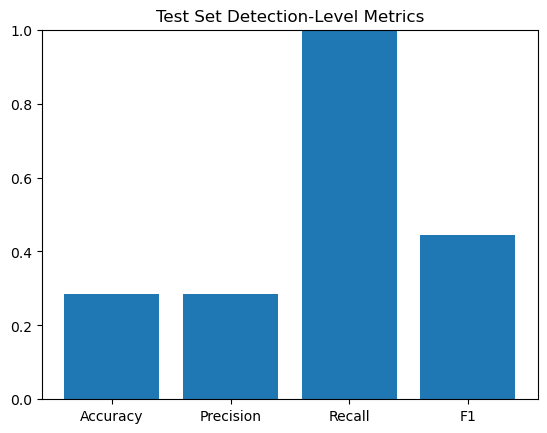

In [43]:
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from monai.networks.nets import BasicUNet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised
)

# ==== SETUP ====
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== PATHS ====
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# ==== LOAD METADATA ====
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

# ==== UTILS ====
def load_dicom_volume(proxid, series_description):
    patient_dir = os.path.join(DICOM_ROOT, proxid)

    # Flexible matching for known sequence types
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d", "ep2ddiff"]
    }

    # Get keywords for this series
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])

    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")


def load_ktrans(proxid):
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    if os.path.exists(path):
        return sitk.ReadImage(path)
    raise FileNotFoundError(f"{proxid}: Ktrans missing.")

def parse_ijk(ijk_str):
    try:
        parts = ijk_str.strip().replace(",", " ").split()
        return tuple(map(int, parts))
    except:
        return None

def generate_label_mask(image, ijk_list):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try:
            label[int(k), int(j), int(i)] = 1
        except:
            continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

# ==== BUILD DATASET ====
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print("📦 Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")

        # Resample to ADC reference space
        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)

        # Get lesion mask
        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        # Save all modalities
        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])

        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f"❌ {proxid}: {e}")

print(f"✅ Total usable samples: {len(data)}")

# ==== BALANCE TRAINING SET ====
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]

seed(42)
no_lesion_sampled = sample(no_lesion, len(has_lesion))

balanced_train_data = has_lesion + no_lesion_sampled
balanced_train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)

_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
train_data = balanced_train_data
train_labels = balanced_train_labels

# ==== TRANSFORMS ====
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    RandGaussianNoised(keys="image", prob=0.2),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)

# ==== MODEL ====
model = BasicUNet(spatial_dims=3, in_channels=4, out_channels=2).to(device)
loss_fn = DiceFocalLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ==== TRAIN ====
print("🚀 Training...")
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "prostate_seg_model.pth")
print("✅ Model saved")

# ==== EVALUATE ====
print("🧪 Evaluating...")
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()

        y_true.append(int(np.any(true_mask)))
        y_pred.append(int(np.any(pred_mask)))

# ==== METRICS ====
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

nonzero_preds = sum(np.any(p) for p in y_pred)
print(f"🧠 Lesions predicted in test set: {nonzero_preds} / {len(test_data)}")

print("\n📊 Test Set Detection-Level Metrics:")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# ==== PLOT ====
plt.bar(["Accuracy", "Precision", "Recall", "F1"], [acc, prec, rec, f1])
plt.ylim(0, 1)
plt.title("Test Set Detection-Level Metrics")
plt.show()


📦 Building dataset...


100%|██████████| 101/101 [00:20<00:00,  4.85it/s]


✅ Total usable samples: 101
BasicUNet features: (32, 32, 64, 128, 256, 32).
🚀 Training...
[Epoch 1] Loss: 28.2056
💾 New best model saved with F1: 0.4444
[Epoch 2] Loss: 26.3756
[Epoch 3] Loss: 25.3496
[Epoch 4] Loss: 24.8385
[Epoch 5] Loss: 24.5204
[Epoch 6] Loss: 24.2325
[Epoch 7] Loss: 24.0001
[Epoch 8] Loss: 23.7976
[Epoch 9] Loss: 23.6225
[Epoch 10] Loss: 23.4678
[Epoch 11] Loss: 23.3335
[Epoch 12] Loss: 23.1981
[Epoch 13] Loss: 23.0796
[Epoch 14] Loss: 22.9738
[Epoch 15] Loss: 22.8749
[Epoch 16] Loss: 22.7806
[Epoch 17] Loss: 22.6901
[Epoch 18] Loss: 22.6039
[Epoch 19] Loss: 22.5239
[Epoch 20] Loss: 22.4513
[Epoch 21] Loss: 22.3858
[Epoch 22] Loss: 22.3276
[Epoch 23] Loss: 22.2742
[Epoch 24] Loss: 22.2264
[Epoch 25] Loss: 22.1828
[Epoch 26] Loss: 22.1429
[Epoch 27] Loss: 22.1064
[Epoch 28] Loss: 22.0734
[Epoch 29] Loss: 22.0427
[Epoch 30] Loss: 22.0145
✅ Training complete
🧪 Evaluating best model...

📊 Detection Metrics (Test Set):
✅ Accuracy:  0.2857
✅ Precision: 0.2857
✅ Recall: 

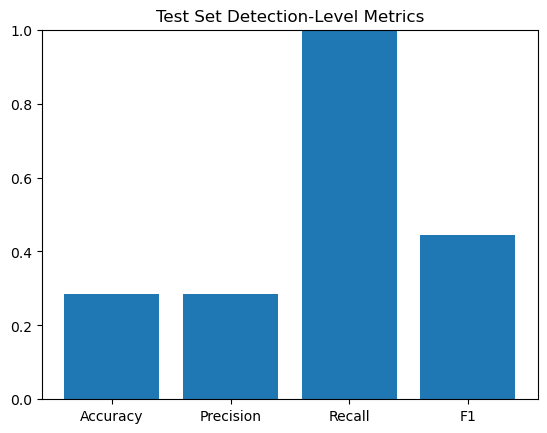

In [45]:
# === IMPORTS ===
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from monai.networks.nets import BasicUNet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised,
    Rand3DElasticd, RandRotated
)
import scipy.ndimage

# === SETUP ===
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS ===
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# === LOAD METADATA ===
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

# === UTILS ===
def load_dicom_volume(proxid, series_description):
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
    }
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])
    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")

def load_ktrans(proxid):
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    if os.path.exists(path):
        return sitk.ReadImage(path)
    raise FileNotFoundError(f"{proxid}: Ktrans missing.")

def parse_ijk(ijk_str):
    try:
        return tuple(map(int, ijk_str.strip().replace(",", " ").split()))
    except:
        return None

def generate_label_mask(image, ijk_list):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try:
            label[int(k), int(j), int(i)] = 1
        except:
            continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

# === DATASET CREATION ===
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print("📦 Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")

        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)

        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])

        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f"❌ {proxid}: {e}")

print(f"✅ Total usable samples: {len(data)}")

# === BALANCE DATA ===
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]
no_lesion_sampled = sample(no_lesion, len(has_lesion))

train_data = has_lesion + no_lesion_sampled
train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# === TRANSFORMS ===
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    Rand3DElasticd(keys=["image", "label"], sigma_range=(1,2), magnitude_range=(1,2), prob=0.2),
    RandRotated(keys=["image", "label"], range_x=np.pi/12, prob=0.3),
    RandGaussianNoised(keys="image", prob=0.2),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)

# === MODEL ===
model = BasicUNet(spatial_dims=3, in_channels=4, out_channels=2).to(device)
loss_fn = DiceFocalLoss(to_onehot_y=True, softmax=True, weight=torch.tensor([0.2, 0.8]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === TRAIN ===
print("🚀 Training...")
best_f1 = 0
for epoch in range(30):  # Increase epochs
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

    # Save best model on F1
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            true_mask = batch["label"].cpu().numpy()
            pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
            pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
            pred_mask = (scipy.ndimage.label(pred_mask)[0] > 0).astype(np.uint8)
            y_true.append(int(np.any(true_mask)))
            y_pred.append(int(np.any(pred_mask)))
    f1 = f1_score(y_true, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"💾 New best model saved with F1: {f1:.4f}")

print("✅ Training complete")

# === EVALUATE BEST MODEL ===
print("🧪 Evaluating best model...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

def post_process_prediction(pred_mask, min_size=100):
    cleaned = []
    for m in pred_mask:
        labeled_array, num_features = scipy.ndimage.label(m)
        sizes = np.bincount(labeled_array.ravel())
        mask_sizes = sizes >= min_size
        mask_sizes[0] = 0
        cleaned_mask = mask_sizes[labeled_array]
        cleaned.append(cleaned_mask.astype(np.uint8))
    return np.array(cleaned)

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = post_process_prediction(pred_mask, min_size=100)

        y_true.append(int(np.any(true_mask)))
        y_pred.append(int(np.any(pred_mask)))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"\n📊 Detection Metrics (Test Set):")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

plt.bar(["Accuracy", "Precision", "Recall", "F1"], [acc, prec, rec, f1])
plt.ylim(0, 1)
plt.title("Test Set Detection-Level Metrics")
plt.show()

# === OPTIONAL VISUALISATION ===
def show_prediction(image, pred, truth):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, :, :, image.shape[3] // 2], cmap='gray')
    plt.title("Input Slice")
    plt.subplot(1, 3, 2)
    plt.imshow(pred[0, :, :, pred.shape[3] // 2])
    plt.title("Predicted Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(truth[0, :, :, truth.shape[3] // 2])
    plt.title("Ground Truth")
    plt.show()


📦 Building dataset...


100%|██████████| 101/101 [00:22<00:00,  4.57it/s]


✅ Total usable samples: 101
🚀 Training...
[Epoch 1] Loss: 25.5673
💾 New best model saved with F1: 0.4444
[Epoch 2] Loss: 24.3762
💾 New best model saved with F1: 0.5000
[Epoch 3] Loss: 24.0174
💾 New best model saved with F1: 0.5455
[Epoch 4] Loss: 23.7808
💾 New best model saved with F1: 0.5556
[Epoch 5] Loss: 23.5794
[Epoch 6] Loss: 23.3959
[Epoch 7] Loss: 23.2451
[Epoch 8] Loss: 23.1094
[Epoch 9] Loss: 22.9600
[Epoch 10] Loss: 22.8427
[Epoch 11] Loss: 22.7382
[Epoch 12] Loss: 22.6456
[Epoch 13] Loss: 22.5638
[Epoch 14] Loss: 22.4893
[Epoch 15] Loss: 22.4200
[Epoch 16] Loss: 22.3589
[Epoch 17] Loss: 22.3032
[Epoch 18] Loss: 22.2526
[Epoch 19] Loss: 22.2079
[Epoch 20] Loss: 22.1653
[Epoch 21] Loss: 22.1265
[Epoch 22] Loss: 22.0912
[Epoch 23] Loss: 22.0585
[Epoch 24] Loss: 22.0272
[Epoch 25] Loss: 21.9973
[Epoch 26] Loss: 21.9700
[Epoch 27] Loss: 21.9453
[Epoch 28] Loss: 21.9229
[Epoch 29] Loss: 21.9026
[Epoch 30] Loss: 21.8840
✅ Training complete
🧪 Evaluating best model...

📊 Test Set De

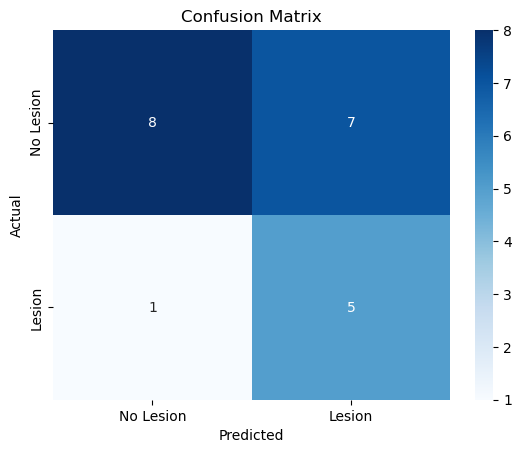

In [49]:
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from monai.networks.nets import AttentionUnet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised,
    Rand3DElasticd, RandRotated
)
from monai.metrics import DiceMetric
import scipy.ndimage
import seaborn as sns

# === SETUP ===
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS ===
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# === LOAD METADATA ===
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

# === UTILS ===
def load_dicom_volume(proxid, series_description):
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
    }
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])
    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")

def load_ktrans(proxid):
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    return sitk.ReadImage(path) if os.path.exists(path) else None

def parse_ijk(ijk_str):
    try: return tuple(map(int, ijk_str.strip().replace(",", " ").split()))
    except: return None

def generate_label_mask(image, ijk_list):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try: label[int(k), int(j), int(i)] = 1
        except: continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

def keep_largest_component(pred_mask):
    cleaned = []
    for m in pred_mask:
        labeled_array, num_features = scipy.ndimage.label(m)
        if num_features == 0:
            cleaned.append(m)
            continue
        sizes = scipy.ndimage.sum(m, labeled_array, range(num_features + 1))
        largest = (labeled_array == np.argmax(sizes)).astype(np.uint8)
        cleaned.append(largest)
    return np.array(cleaned)

# === DATASET BUILD ===
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print("📦 Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")

        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)

        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])

        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f"❌ {proxid}: {e}")

print(f"✅ Total usable samples: {len(data)}")

# === BALANCE ===
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]
no_lesion_sampled = sample(no_lesion, len(has_lesion))
train_data = has_lesion + no_lesion_sampled
train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# === TRANSFORMS ===
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    Rand3DElasticd(keys=["image", "label"], sigma_range=(1,2), magnitude_range=(1,2), prob=0.2),
    RandRotated(keys=["image", "label"], range_x=np.pi/12, prob=0.3),
    RandGaussianNoised(keys="image", prob=0.2),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)

# === MODEL ===
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2)
).to(device)

loss_fn = DiceFocalLoss(to_onehot_y=True, softmax=True, weight=torch.tensor([0.2, 0.8]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# === TRAIN ===
print("🚀 Training...")
best_f1 = 0
for epoch in range(30):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

    # Eval on test for best model
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            true_mask = batch["label"].cpu().numpy()
            pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
            pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
            pred_mask = keep_largest_component(pred_mask)

            lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
            y_pred.append(lesion_detected)
            y_true.append(int(np.any(true_mask)))

    f1 = f1_score(y_true, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"💾 New best model saved with F1: {f1:.4f}")

print("✅ Training complete")

# === EVALUATE ===
print("🧪 Evaluating best model...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = keep_largest_component(pred_mask)

        lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("\n📊 Test Set Detection-Level Metrics:")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lesion", "Lesion"], yticklabels=["No Lesion", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🧪 Evaluating with Dice + Visualisation


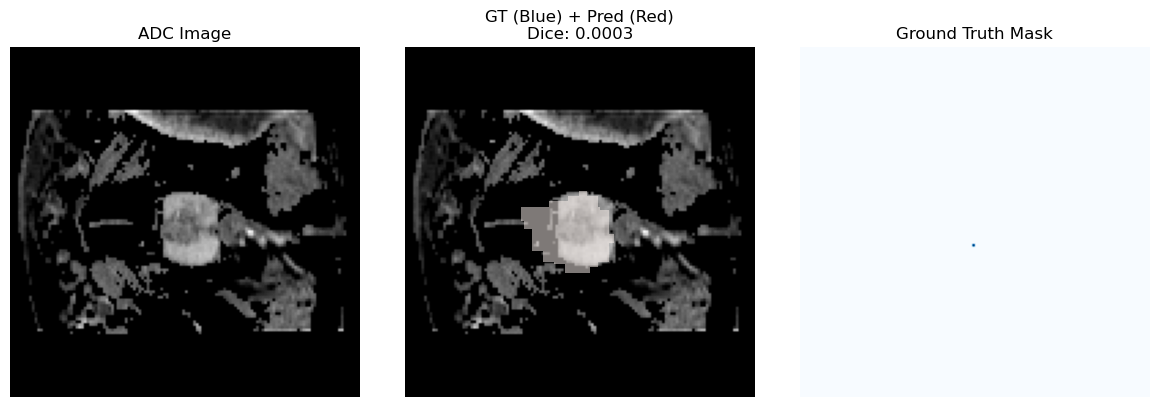

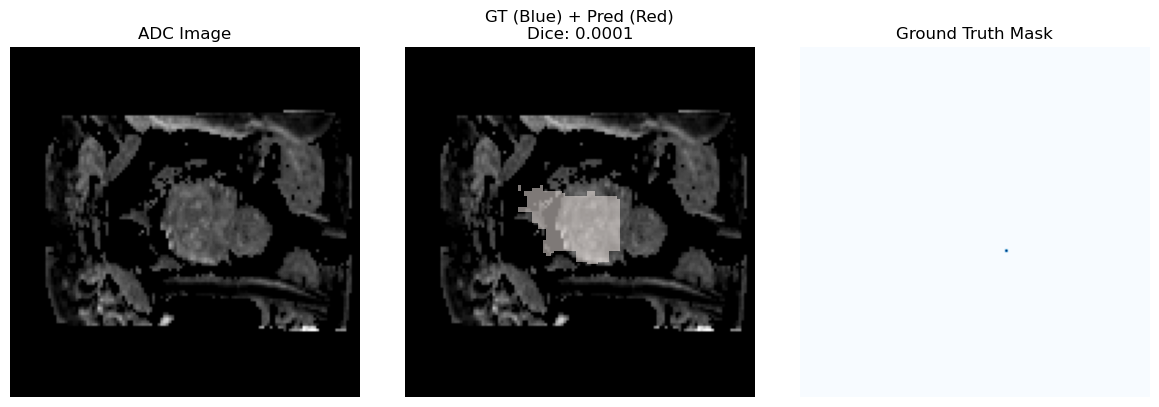

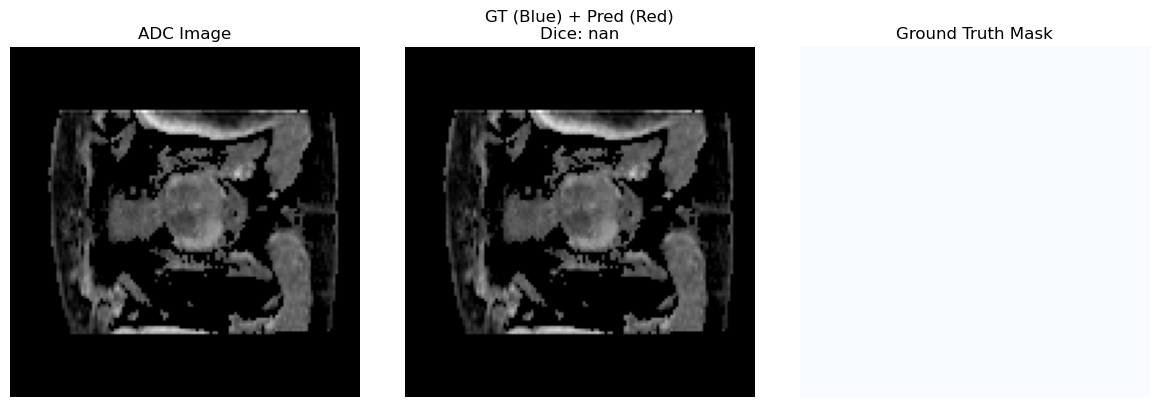

In [69]:
from monai.metrics import DiceMetric
from matplotlib import pyplot as plt

def generate_label_mask(image, ijk_list, radius=2):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dz in range(-radius, radius + 1):
                    xi, yj, zk = i + dx, j + dy, k + dz
                    if 0 <= zk < label.shape[0] and 0 <= yj < label.shape[1] and 0 <= xi < label.shape[2]:
                        label[zk, yj, xi] = 1
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result


def clean_prediction(pred_mask, structure_size=3):
    cleaned = []
    for m in pred_mask:
        m = binary_closing(m, structure=np.ones((structure_size, structure_size, structure_size)))
        cleaned.append(m.astype(np.uint8))
    return np.array(cleaned)


# === Evaluation with Dice Score + Visualisation ===
dice_metric = DiceMetric(include_background=False, reduction="mean")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
dice_scores = []

print("🧪 Evaluating with Dice + Visualisation")
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = keep_largest_component(pred_mask)
        pred_mask = clean_prediction(pred_mask, structure_size=3)

        lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

        # === Dice calculation (if lesion present in GT or prediction) ===
        if np.any(pred_mask) or np.any(true_mask):
            pred_tensor = torch.tensor(pred_mask).unsqueeze(1)
            true_tensor = torch.tensor(true_mask, dtype=torch.uint8).unsqueeze(1)
            dice = dice_metric(pred_tensor, true_tensor).item()
            dice_scores.append(dice)

        # === Visualise first 3 patients only ===
        if idx < 3:
            # Use ADC instead of T2 for overlay
            img = images[0][0].cpu().numpy()  # ADC image (resample reference)
            slice_idx = img.shape[2] // 2
        
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        
            # T2 image (unchanged)
            axs[0].imshow(img[:, :, slice_idx], cmap="gray")
            axs[0].set_title("ADC Image")
            axs[0].axis("off")
        
            # Overlay both prediction and ground truth
            pred_overlay = np.ma.masked_where(pred_mask[0][:, :, slice_idx] == 0, pred_mask[0][:, :, slice_idx])
            gt_overlay = np.ma.masked_where(true_mask[0].squeeze()[:, :, slice_idx] == 0, true_mask[0].squeeze()[:, :, slice_idx])
        
            axs[1].imshow(img[:, :, slice_idx], cmap="gray")
            axs[1].imshow(gt_overlay, cmap="Blues", alpha=0.5)
            axs[1].imshow(pred_overlay, cmap="Reds", alpha=0.5)
            axs[1].set_title(f"GT (Blue) + Pred (Red)\nDice: {dice:.4f}")
            axs[1].axis("off")
        
            # Ground Truth only for reference
            axs[2].imshow(true_mask[0].squeeze()[:, :, slice_idx], cmap="Blues")
            axs[2].set_title("Ground Truth Mask")
            axs[2].axis("off")
        
            plt.tight_layout()
            plt.show()





📦 Building dataset...


100%|██████████| 101/101 [00:22<00:00,  4.58it/s]


✅ Total usable samples: 101
🚀 Training...
[Epoch 1] Loss: 99.1086
💾 New best model saved with F1: 0.4762
[Epoch 2] Loss: 86.6354
[Epoch 3] Loss: 80.6754
[Epoch 4] Loss: 75.9346
💾 New best model saved with F1: 0.5333
[Epoch 5] Loss: 72.1682
[Epoch 6] Loss: 69.1111
[Epoch 7] Loss: 66.4962
[Epoch 8] Loss: 64.3407
[Epoch 9] Loss: 62.9456
[Epoch 10] Loss: 62.1292
[Epoch 11] Loss: 61.3354
[Epoch 12] Loss: 60.6021
[Epoch 13] Loss: 60.0850
[Epoch 14] Loss: 59.7516
[Epoch 15] Loss: 59.4237
[Epoch 16] Loss: 59.1079
[Epoch 17] Loss: 58.8711
[Epoch 18] Loss: 58.7159
[Epoch 19] Loss: 58.5616
[Epoch 20] Loss: 58.4029
[Epoch 21] Loss: 58.2843
[Epoch 22] Loss: 58.2061
[Epoch 23] Loss: 58.1274
[Epoch 24] Loss: 58.0473
[Epoch 25] Loss: 57.9845
[Epoch 26] Loss: 57.9433
[Epoch 27] Loss: 57.9016
[Epoch 28] Loss: 57.8587
[Epoch 29] Loss: 57.8255
[Epoch 30] Loss: 57.8055
✅ Training complete
🧪 Evaluating best model...

📊 Test Set Detection-Level Metrics:
✅ Accuracy:  0.6667
✅ Precision: 0.4444
✅ Recall:    0.

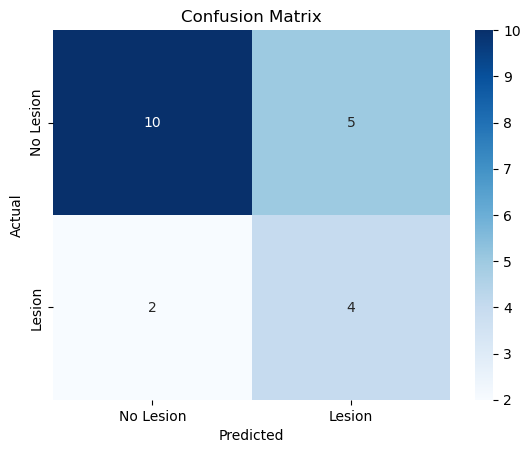

In [73]:
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from monai.networks.nets import AttentionUnet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised,
    Rand3DElasticd, RandRotated, RandFlipd, RandShiftIntensityd
)
from monai.metrics import DiceMetric
import scipy.ndimage
import seaborn as sns

# === SETUP ===
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS ===
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# === LOAD METADATA ===
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

# === UTILS ===
def load_dicom_volume(proxid, series_description):
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
    }
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])
    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")

def load_ktrans(proxid):
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    return sitk.ReadImage(path) if os.path.exists(path) else None

def parse_ijk(ijk_str):
    try: return tuple(map(int, ijk_str.strip().replace(",", " ").split()))
    except: return None

def generate_label_mask(image, ijk_list):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try: label[int(k), int(j), int(i)] = 1
        except: continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

def keep_largest_component(pred_mask):
    cleaned = []
    for m in pred_mask:
        labeled_array, num_features = scipy.ndimage.label(m)
        if num_features == 0:
            cleaned.append(m)
            continue
        sizes = scipy.ndimage.sum(m, labeled_array, range(num_features + 1))
        largest = (labeled_array == np.argmax(sizes)).astype(np.uint8)
        cleaned.append(largest)
    return np.array(cleaned)

# === DATASET BUILD ===
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print("📦 Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")

        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)

        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)

        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])

        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f"❌ {proxid}: {e}")

print(f"✅ Total usable samples: {len(data)}")

# === BALANCE ===
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]
neg_to_pos_ratio = 3
no_lesion_sampled = sample(no_lesion, min(len(no_lesion), len(has_lesion) * neg_to_pos_ratio))
train_data = has_lesion + no_lesion_sampled
train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


# === TRANSFORMS ===

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.3),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.3),
    RandGaussianNoised(keys="image", prob=0.2),
    RandAffined(keys=["image", "label"], prob=0.3, translate_range=5),
    RandRotated(keys=["image", "label"], range_x=np.pi/12, prob=0.3),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])


test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])

train_loader = DataLoader(Dataset(train_data, transform=train_transforms), batch_size=1, shuffle=True)
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)

# === MODEL ===
from monai.losses import DiceCELoss

model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2)
).to(device)

loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

def tta_sliding_window(model, images):
    flips = [lambda x: x, lambda x: torch.flip(x, dims=[2])]
    preds = []
    for flip in flips:
        flipped = flip(images)
        pred = sliding_window_inference(flipped, (128, 128, 64), 1, model)
        pred = flip(pred)
        preds.append(pred)
    return torch.mean(torch.stack(preds), dim=0)

def lesion_present(pred_mask, threshold=0.5, min_voxels=300):
    probs = torch.softmax(pred_mask, dim=1)[:, 1].cpu().numpy()
    binary = (probs > threshold).astype(np.uint8)
    binary = keep_largest_component(binary)
    return int(np.any(binary) and binary.sum() > min_voxels)



# === TRAIN ===
print("🚀 Training...")
best_f1 = 0
for epoch in range(30):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")

    # Eval on test for best model
    model.eval()
    y_true, y_pred = [], []
    # Evaluation (same for final eval too)
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            true_mask = batch["label"].cpu().numpy()
            pred_mask = tta_sliding_window(model, images)
            detected = lesion_present(pred_mask)
            y_pred.append(detected)
            y_true.append(int(np.any(true_mask)))


    f1 = f1_score(y_true, y_pred, zero_division=0)
    scheduler.step(f1)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"💾 New best model saved with F1: {f1:.4f}")

print("✅ Training complete")

# === EVALUATE ===
print("🧪 Evaluating best model...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = tta_sliding_window(model, images)
        lesion_detected = lesion_present(pred_mask)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("\n📊 Test Set Detection-Level Metrics:")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lesion", "Lesion"], yticklabels=["No Lesion", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🧪 Evaluating with Dice + Visualisation


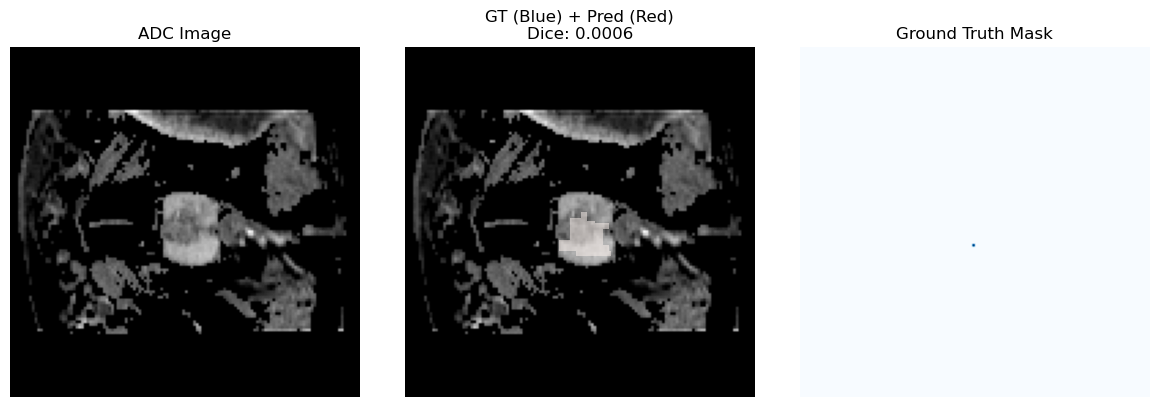

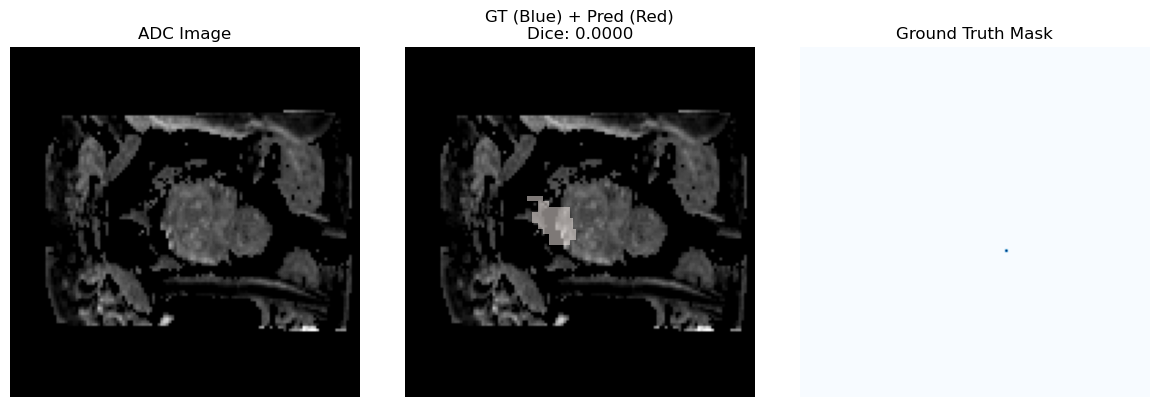

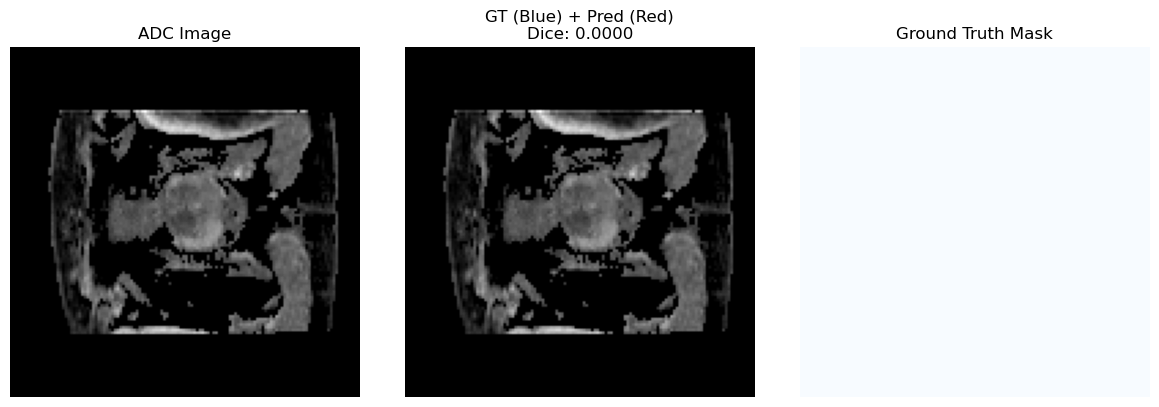

In [75]:
from monai.metrics import DiceMetric
from matplotlib import pyplot as plt

def generate_label_mask(image, ijk_list, radius=2):
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dz in range(-radius, radius + 1):
                    xi, yj, zk = i + dx, j + dy, k + dz
                    if 0 <= zk < label.shape[0] and 0 <= yj < label.shape[1] and 0 <= xi < label.shape[2]:
                        label[zk, yj, xi] = 1
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result


def clean_prediction(pred_mask, structure_size=3):
    cleaned = []
    for m in pred_mask:
        m = binary_closing(m, structure=np.ones((structure_size, structure_size, structure_size)))
        cleaned.append(m.astype(np.uint8))
    return np.array(cleaned)


# === Evaluation with Dice Score + Visualisation ===
dice_metric = DiceMetric(include_background=False, reduction="mean")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
dice_scores = []

print("🧪 Evaluating with Dice + Visualisation")
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = sliding_window_inference(images, (128, 128, 64), 1, model)
        pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
        pred_mask = keep_largest_component(pred_mask)
        pred_mask = clean_prediction(pred_mask, structure_size=3)

        lesion_detected = int(np.any(pred_mask) and pred_mask.sum() > 500)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

        # === Dice calculation (if lesion present in GT or prediction) ===
        if np.any(pred_mask) or np.any(true_mask):
            pred_tensor = torch.tensor(pred_mask).unsqueeze(1)
            true_tensor = torch.tensor(true_mask, dtype=torch.uint8).unsqueeze(1)
            dice = dice_metric(pred_tensor, true_tensor).item()
            dice_scores.append(dice)

        # === Visualise first 3 patients only ===
        if idx < 3:
            # Use ADC instead of T2 for overlay
            img = images[0][0].cpu().numpy()  # ADC image (resample reference)
            slice_idx = img.shape[2] // 2
        
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        
            # T2 image (unchanged)
            axs[0].imshow(img[:, :, slice_idx], cmap="gray")
            axs[0].set_title("ADC Image")
            axs[0].axis("off")
        
            # Overlay both prediction and ground truth
            pred_overlay = np.ma.masked_where(pred_mask[0][:, :, slice_idx] == 0, pred_mask[0][:, :, slice_idx])
            gt_overlay = np.ma.masked_where(true_mask[0].squeeze()[:, :, slice_idx] == 0, true_mask[0].squeeze()[:, :, slice_idx])
        
            axs[1].imshow(img[:, :, slice_idx], cmap="gray")
            axs[1].imshow(gt_overlay, cmap="Blues", alpha=0.5)
            axs[1].imshow(pred_overlay, cmap="Reds", alpha=0.5)
            axs[1].set_title(f"Dice: {dice:.4f}")
            axs[1].axis("off")
        
            # Ground Truth only for reference
            axs[2].imshow(true_mask[0].squeeze()[:, :, slice_idx], cmap="Blues")
            axs[2].set_title("Ground Truth Mask")
            axs[2].axis("off")
        
            plt.tight_layout()
            plt.show()



